<a href="https://colab.research.google.com/github/Bahrombekk/pytorch/blob/main/%22%22Data_AI_ipynb%22_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,random_split
import torch.nn.functional as F
import glob

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
# from torchinfo import summary
from torchsummary import summary
import pathlib
from PIL import Image
from torchvision.transforms import transforms
from torch.optim import Adam

import torchvision.transforms as T

In [2]:
!pip install torchinfo

#Kompiyuter va telifon

In [3]:
! wget -O dataset.zip https://www.dropbox.com/s/e5f4epncmydijrw/Komp_in_tel.zip?dl=0

--2023-07-12 12:04:24--  https://www.dropbox.com/s/e5f4epncmydijrw/Komp_in_tel.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/e5f4epncmydijrw/Komp_in_tel.zip [following]
--2023-07-12 12:04:24--  https://www.dropbox.com/s/raw/e5f4epncmydijrw/Komp_in_tel.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uceea8070a504c6bb335fe8f5c6e.dl.dropboxusercontent.com/cd/0/inline/B_uN95cROoO48PfWMc-AtRnSNAhwRNFgIuYciv556GeGir8ZIfKabK_Ezkvl-HgT0Vd4piIsUEvQ8VtAyAFJVnbEsoRkEOQrZSows2h1qEBYYLZyhEDASwxpA-9hPDTATYS12ofhwW2XNw3d-CIYHZTYiZKh2WjiTjhTx650RFn5Ew/file# [following]
--2023-07-12 12:04:25--  https://uceea8070a504c6bb335fe8f5c6e.dl.dropboxusercontent.com/cd/0/inline/B_uN95cROoO48PfWMc-AtRnSNAhwRNFgIuYciv556GeGir8ZIfKabK_Ezkvl-HgT0V

In [ ]:
!unzip dataset.zip

In [54]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [55]:
transform = T.Compose([
    T.Resize(size=(150,150)),
    T.ToTensor()
])

In [56]:
class KOMP_in_tel_Dataset(Dataset):
    def __init__(self, path, transform = None):
        self.path_list = list(path.glob('*/*.jpg'))
        self.transform = transform
    def __getitem__(self,index):
        img = Image.open(self.path_list[index])
        label = (self.path_list[index]).parts[-2]
        label = 0 if 'kompiyuter' in label else 1
        if transform != None:
            img = transform(img)
        return img, int(label)
    def __len__(self):
        return len(self.path_list)

In [57]:
train_path = pathlib.Path('/content/Komp_in_tel/train')
test_path = pathlib.Path('/content/Komp_in_tel/validation')

In [58]:
train_dataset = KOMP_in_tel_Dataset(train_path, transform)
test_dataset = KOMP_in_tel_Dataset(test_path, transform)

In [59]:
path_list = list(train_path.glob('*/*.jpg'))
path_test=list(test_path.glob('*/*.jpg'))

In [60]:
train_data = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=1000, shuffle=True)

In [61]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output=output.view(-1,32*75*75)
        output=self.fc(output)
        return output


In [62]:
model=ConvNet()

In [63]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [64]:
num_epochs = 5

In [65]:
class Trainer:
    def __init__(self, model, train_dataloader, test_dataloader, criterion, optimizer, epochs=3):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.history = {'loss':[],'acc':[],'val_loss':[],'val_acc':[]}
    def train_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.train_dataloader)
        for i, (data,label) in enumerate(tqdm(self.train_dataloader)):
            data = data.to(device)
            label = label.to(device)
            output = self.model(data)
            loss = self.criterion(output, label)
            sum_loss += loss.item()
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_accuracy += n_corrects/label.size(0)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
        train_loss = sum_loss/n
        train_accuracy = sum_accuracy/n
        self.history['loss'].append(train_loss)
        self.history['acc'].append(train_accuracy)
        return train_loss, train_accuracy
    def validation_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.test_dataloader)
        for i, (data,label) in enumerate(tqdm(self.test_dataloader)):
            data = data.to(device)
            label = label.to(device)
            output = self.model(data)
            loss = self.criterion(output, label)
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_loss += loss.item()
            sum_accuracy += n_corrects/label.size(0)
        val_loss = sum_loss/n
        val_accuracy = sum_accuracy/n
        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_accuracy)
        return val_loss, val_accuracy
    def train(self):
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_loop()
            val_loss, val_acc = self.validation_loop()
            print()
            print(f'Epoch[{epoch+1}/{num_epochs}] \t train_loss: {train_loss:.5f}, train_acc: {train_acc:.2f} \t val_loss: {val_loss:.5f} \t val_acc: {val_acc:.2}')


In [66]:
trainer = Trainer(
    model = model.to(device),
    train_dataloader = train_data,
    test_dataloader = test_data,
    criterion=criterion,
    optimizer=optimizer
)

In [67]:
trainer.train()

100%|██████████| 1/1 [00:00<00:00, 10.10it/s]



Epoch[1/5] 	 train_loss: 2.89756, train_acc: 0.88 	 val_loss: 0.89158 	 val_acc: 0.9


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]



Epoch[2/5] 	 train_loss: 0.23423, train_acc: 0.99 	 val_loss: 13.35226 	 val_acc: 0.6


100%|██████████| 1/1 [00:00<00:00, 10.66it/s]



Epoch[3/5] 	 train_loss: 0.17563, train_acc: 0.99 	 val_loss: 1.73015 	 val_acc: 0.9


100%|██████████| 1/1 [00:00<00:00, 10.62it/s]



Epoch[4/5] 	 train_loss: 0.14747, train_acc: 0.99 	 val_loss: 0.00000 	 val_acc: 1.0


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


Epoch[5/5] 	 train_loss: 0.17425, train_acc: 0.99 	 val_loss: 3.29795 	 val_acc: 0.7


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
[[0 0]
 [3 7]]


<Axes: >

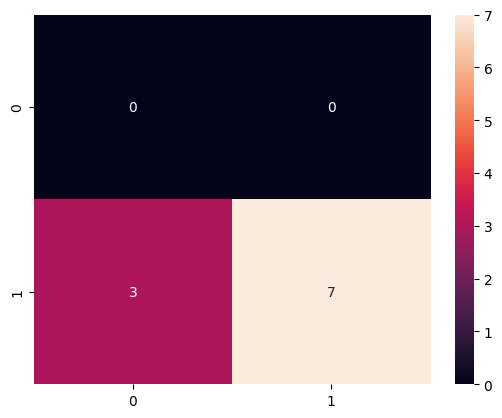

In [68]:
test_img,test_label=next(iter(test_data))
pred=model(test_img.to(device))
pred=pred.argmax(axis=1)
pred = pred.detach().cpu()
from sklearn.metrics import confusion_matrix
print( test_label)
cm=confusion_matrix(test_label,pred)
print(cm)
import seaborn as sns
sns.heatmap(cm,annot=True)

#Stol kompiyuteri va novutbuk

In [20]:
! wget -O dataset.zip https://www.dropbox.com/s/fdlnoh5stmumy0d/Kompiyuter.zip?dl=0

--2023-07-12 12:08:12--  https://www.dropbox.com/s/fdlnoh5stmumy0d/Kompiyuter.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/fdlnoh5stmumy0d/Kompiyuter.zip [following]
--2023-07-12 12:08:12--  https://www.dropbox.com/s/raw/fdlnoh5stmumy0d/Kompiyuter.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc558c55423e64256920780f8278.dl.dropboxusercontent.com/cd/0/inline/B_tFHEKiJhTX1fUNnxbFHaAuhNxPTddbnU2Ld8WeWxTG4UKtNz2Hqv0ZPisWOMAeUP77KLAE0VuQ1PdUEgNcfK1eAy0l0dnvJ8OjXgRVB6z2u9rIByp8IpeWAHa1OiVWJ4CVAaMyl9g7j0NuaqxS0bvUp0O5zdCe1ts4SoGIwnmKxg/file# [following]
--2023-07-12 12:08:13--  https://uc558c55423e64256920780f8278.dl.dropboxusercontent.com/cd/0/inline/B_tFHEKiJhTX1fUNnxbFHaAuhNxPTddbnU2Ld8WeWxTG4UKtNz2Hqv0ZPisWOMAeUP77K

In [ ]:
!unzip dataset.zip

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [23]:
transform = T.Compose([
    T.Resize(size=(150,150)),
    T.ToTensor()
])

In [24]:
class KompyuterDataset(Dataset):
    def __init__(self, path, transform = None):
        self.path_list = list(path.glob('*/*.jpg'))
        self.transform = transform
    def __getitem__(self,index):
        img = Image.open(self.path_list[index])
        label = (self.path_list[index]).parts[-2]
        label = 0 if 'kompiyuter' in label else 1
        if transform != None:
            img = transform(img)
        return img, int(label)
    def __len__(self):
        return len(self.path_list)

In [25]:
train_path = pathlib.Path('/content/Kompiyuter/train')
test_path = pathlib.Path('/content/Kompiyuter/validation')

In [26]:
train_dataset = KompyuterDataset(train_path, transform)
test_dataset = KompyuterDataset(test_path, transform)

In [27]:
path_list = list(train_path.glob('*/*.jpg'))
path_test=list(test_path.glob('*/*.jpg'))

In [28]:
train_data = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=2000, shuffle=True)

In [29]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output=output.view(-1,32*75*75)
        output=self.fc(output)
        return output


In [30]:
model=ConvNet()

In [31]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [32]:
num_epochs = 5

In [33]:
class Trainer:
    def __init__(self, model, train_dataloader, test_dataloader, criterion, optimizer, epochs=3):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.history = {'loss':[],'acc':[],'val_loss':[],'val_acc':[]}
    def train_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.train_dataloader)
        for i, (data,label) in enumerate(tqdm(self.train_dataloader)):
            data = data.to(device)
            label = label.to(device)
            output = self.model(data)
            loss = self.criterion(output, label)
            sum_loss += loss.item()
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_accuracy += n_corrects/label.size(0)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
        train_loss = sum_loss/n
        train_accuracy = sum_accuracy/n
        self.history['loss'].append(train_loss)
        self.history['acc'].append(train_accuracy)
        return train_loss, train_accuracy
    def validation_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.test_dataloader)
        for i, (data,label) in enumerate(tqdm(self.test_dataloader)):
            data = data.to(device)
            label = label.to(device)
            output = self.model(data)
            loss = self.criterion(output, label)
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_loss += loss.item()
            sum_accuracy += n_corrects/label.size(0)
        val_loss = sum_loss/n
        val_accuracy = sum_accuracy/n
        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_accuracy)
        return val_loss, val_accuracy
    def train(self):
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_loop()
            val_loss, val_acc = self.validation_loop()
            print()
            print(f'Epoch[{epoch+1}/{num_epochs}] \t train_loss: {train_loss:.5f}, train_acc: {train_acc:.2f} \t val_loss: {val_loss:.5f} \t val_acc: {val_acc:.2}')


In [34]:
trainer = Trainer(
    model = model.to(device),
    train_dataloader = train_data,
    test_dataloader = test_data,
    criterion=criterion,
    optimizer=optimizer
)

In [35]:
trainer.train()

100%|██████████| 1/1 [00:00<00:00,  5.07it/s]



Epoch[1/5] 	 train_loss: 9.36451, train_acc: 0.78 	 val_loss: 6.70759 	 val_acc: 0.6


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]



Epoch[2/5] 	 train_loss: 0.00180, train_acc: 1.00 	 val_loss: 3.92675 	 val_acc: 0.75


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]



Epoch[3/5] 	 train_loss: 0.00013, train_acc: 1.00 	 val_loss: 4.72831 	 val_acc: 0.75


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]



Epoch[4/5] 	 train_loss: 0.00136, train_acc: 1.00 	 val_loss: 3.56377 	 val_acc: 0.75


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch[5/5] 	 train_loss: 0.00003, train_acc: 1.00 	 val_loss: 5.13183 	 val_acc: 0.75


tensor([1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1])
[[10  0]
 [ 5  5]]


<Axes: >

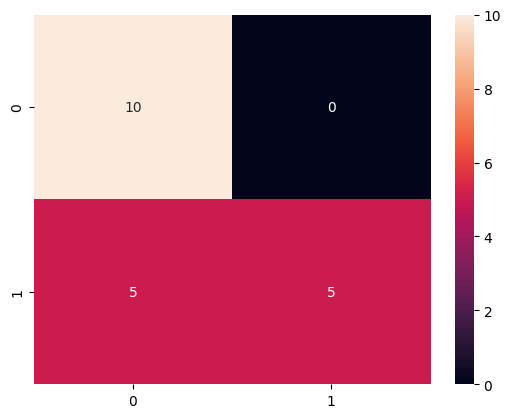

In [36]:
test_img,test_label=next(iter(test_data))
pred=model(test_img.to(device))
pred=pred.argmax(axis=1)
pred = pred.detach().cpu()
from sklearn.metrics import confusion_matrix
print( test_label)
cm=confusion_matrix(test_label,pred)
print(cm)
import seaborn as sns
sns.heatmap(cm,annot=True)

#Teztibbiy yordam va Politsiya moshinalari

In [37]:
! wget -O tezyordam_in_polis.zip https://www.dropbox.com/s/zbrbvyj6la2jivv/Tez_in_polis.zip?dl=0

--2023-07-12 12:11:50--  https://www.dropbox.com/s/zbrbvyj6la2jivv/Tez_in_polis.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zbrbvyj6la2jivv/Tez_in_polis.zip [following]
--2023-07-12 12:11:50--  https://www.dropbox.com/s/raw/zbrbvyj6la2jivv/Tez_in_polis.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc71193c9e39669071b2cb29cd25.dl.dropboxusercontent.com/cd/0/inline/B_twIkORaDraEcyMwFw9bGSuCNd3SYpl253MA8fNCoEL0B8bY4EZZUDSVYNqsDdvkrOO6OykULpAbX28r9Iqc5Ism8Tv_6NY2XvBzTL-kfKlpr-Ll3KnekM-q-b9qV8JlThQDUSicpUAbGsieRYWssY7XbIBqNyEoQJak5lZ4B767w/file# [following]
--2023-07-12 12:11:51--  https://uc71193c9e39669071b2cb29cd25.dl.dropboxusercontent.com/cd/0/inline/B_twIkORaDraEcyMwFw9bGSuCNd3SYpl253MA8fNCoEL0B8bY4EZZUDSVYNqsDd

In [ ]:
!unzip tezyordam_in_polis.zip

In [39]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [40]:
transform = T.Compose([
    T.Resize(size=(150,150)),
    T.ToTensor()
])

In [41]:
class Tez_in_pol_Dataset(Dataset):
    def __init__(self, path, transform = None):
        self.path_list = list(path.glob('*/*.jpg'))
        self.transform = transform
    def __getitem__(self,index):
        img = Image.open(self.path_list[index])
        label = (self.path_list[index]).parts[-2]
        label = 0 if 'Polis' in label else 1
        if transform != None:
            img = transform(img)
        return img, int(label)
    def __len__(self):
        return len(self.path_list)

In [42]:
train_path = pathlib.Path('/content/Tez_in_polis/tren')
test_path = pathlib.Path('/content/Tez_in_polis/test')

In [43]:
train_dataset = Tez_in_pol_Dataset(train_path, transform)
test_dataset = Tez_in_pol_Dataset(test_path, transform)

In [44]:
path_list = list(train_path.glob('*/*.jpg'))
path_test=list(test_path.glob('*/*.jpg'))

In [45]:
train_data = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=5000, shuffle=True)

In [46]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()

        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()

        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output=output.view(-1,32*75*75)
        output=self.fc(output)
        return output


In [47]:
model=ConvNet()

In [48]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [49]:
num_epochs = 5

In [50]:
class Trainer:
    def __init__(self, model, train_dataloader, test_dataloader, criterion, optimizer, epochs=3):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.criterion = criterion
        self.optimizer = optimizer

        self.epochs = epochs
        self.history = {'loss':[],'acc':[],'val_loss':[],'val_acc':[]}
    def train_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.train_dataloader)
        for i, (data,label) in enumerate(tqdm(self.train_dataloader)):
            data = data.to(device)
            label = label.to(device)
            output = self.model(data)
            loss = self.criterion(output, label)
            sum_loss += loss.item()
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_accuracy += n_corrects/label.size(0)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
        train_loss = sum_loss/n
        train_accuracy = sum_accuracy/n
        self.history['loss'].append(train_loss)
        self.history['acc'].append(train_accuracy)
        return train_loss, train_accuracy
    def validation_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.test_dataloader)
        for i, (data,label) in enumerate(tqdm(self.test_dataloader)):
            data = data.to(device)
            label = label.to(device)
            output = self.model(data)
            loss = self.criterion(output, label)
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_loss += loss.item()
            sum_accuracy += n_corrects/label.size(0)
        val_loss = sum_loss/n
        val_accuracy = sum_accuracy/n
        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_accuracy)
        return val_loss, val_accuracy
    def train(self):
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_loop()
            val_loss, val_acc = self.validation_loop()
            print()
            print(f'Epoch[{epoch+1}/{num_epochs}] \t train_loss: {train_loss:.5f}, train_acc: {train_acc:.2f} \t val_loss: {val_loss:.5f} \t val_acc: {val_acc:.2}')


In [51]:
trainer = Trainer(
    model = model.to(device),
    train_dataloader = train_data,
    test_dataloader = test_data,
    criterion=criterion,
    optimizer=optimizer
)

In [52]:
trainer.train()

100%|██████████| 1/1 [00:01<00:00,  1.51s/it]



Epoch[1/5] 	 train_loss: 2.80982, train_acc: 0.88 	 val_loss: 2.49112 	 val_acc: 0.92


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]



Epoch[2/5] 	 train_loss: 0.13466, train_acc: 0.99 	 val_loss: 2.66506 	 val_acc: 0.93


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]



Epoch[3/5] 	 train_loss: 0.09514, train_acc: 0.99 	 val_loss: 2.28523 	 val_acc: 0.87


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]



Epoch[4/5] 	 train_loss: 0.20284, train_acc: 0.99 	 val_loss: 4.42426 	 val_acc: 0.87


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Epoch[5/5] 	 train_loss: 0.17496, train_acc: 0.99 	 val_loss: 4.63826 	 val_acc: 0.87


tensor([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1])
[[27  3]
 [ 5 25]]


<Axes: >

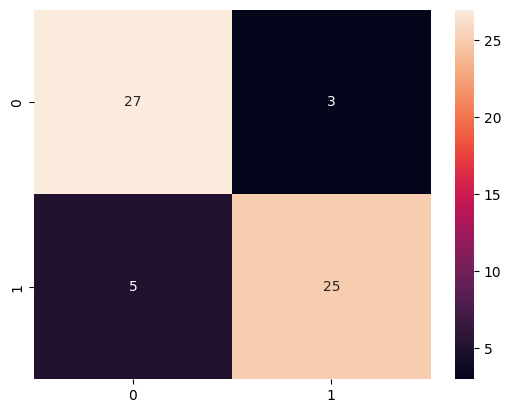

In [53]:
test_img,test_label=next(iter(test_data))
pred=model(test_img.to(device))
pred=pred.argmax(axis=1)
pred = pred.detach().cpu()
from sklearn.metrics import confusion_matrix
print( test_label)
cm=confusion_matrix(test_label,pred)
print(cm)
import seaborn as sns
sns.heatmap(cm,annot=True)